#**Mid-Term Project : Predicting House Prices** 

##**Noam Atias - 311394357**

##**Channel Michaeli - 208491787**

Our job is to predict the sales price for each house.
For each Id in the test set, we need to predict the value of the SalePrice variable.
Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)
For this competition, we will use RidgeCV Regression to predict the house price. 



Ridge regression is a model tuning method that is used to analyze any data that suffers from multicollinearity. This method performs L2 regularization. When the issue of multicollinearity occurs, least-squares are unbiased, and variances are large, this results in predicted values being far away from the actual values. 
Lambda is the penalty term. λ given here is denoted by an alpha parameter in the ridge function. So, by changing the values of alpha, we are controlling the penalty term. The higher the values of alpha, the bigger is the penalty and therefore the magnitude of coefficients is reduced.



##**Import Packages and Datasets**

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.stats import norm, skew

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
file_path1 = '/content/gdrive/My Drive/Colab Notebooks/house-prices-advanced-regression-techniques/train.csv'
file_path2 = '/content/gdrive/My Drive/Colab Notebooks/house-prices-advanced-regression-techniques/test.csv'

In [ ]:
train = pd.read_csv(file_path1)
test = pd.read_csv(file_path2)

##**Data Analysis**

In [ ]:
print("The train data size before dropping Id feature is : {}  ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1460, 81)  
The test data size before dropping Id feature is : (1459, 80) 


###**1. Sample Train Dataset**

In [ ]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


###**2. Sample Test Dataset**

In [ ]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


###**3. The Feaures In The Dataset**

In [ ]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

###**4. Train Dataset Statistics**

In [ ]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


###**5. Summary statistics for categorical values**

In [ ]:
display(train.describe(include= ['O']))
display(test.describe(include= ['O']))

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1452,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,864,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1455,1459,107,1459,1459,1457,1459,1459,1459,1459,1459,1459,1459,1459,1459,1458,1458,1443,1459,1459,1459,1415,1414,1415,1417,1417,1459,1459,1459,1459,1458,1457,729,1383,1381,1381,1381,1459,3,290,51,1458,1459
unique,5,2,2,4,4,1,5,3,25,9,5,5,7,6,4,13,15,4,4,5,6,4,4,4,6,6,4,5,2,4,4,7,5,6,3,4,5,3,2,4,3,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal
freq,1114,1453,70,934,1311,1457,1081,1396,218,1251,1444,1205,745,1169,1442,510,510,878,892,1256,661,634,1295,951,431,1237,1446,752,1358,1337,757,1357,364,853,625,1293,1328,1301,2,172,46,1258,1204


###**6. Checking the Correlation between the variables and the target variable**

In [ ]:
print(train.corr()['SalePrice'].sort_values(ascending=False))

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

The top 6 variables with the best correlation :

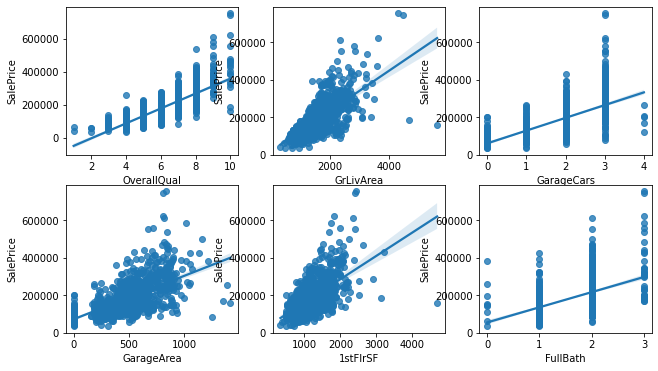

In [ ]:
top_6_corr=['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', '1stFlrSF', 'FullBath']
prows = 2
pcols = 3
fig, axs = plt.subplots(prows, pcols, figsize=(pcols*3.5, prows*3))
for r in range(0,prows):
    for c in range(0,pcols):  
        i = r*pcols+c
        col=top_6_corr[i]
        sns.regplot(x=train[col], y=train['SalePrice'], ax = axs[r][c])

##**Data Preprocessing**

##**1. Outliers**##

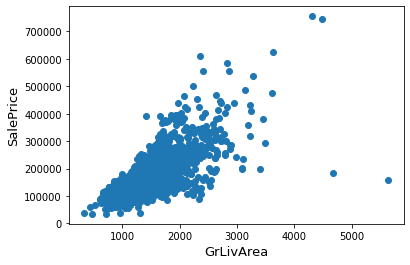

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

We can see that the points in the lower right corner have extremely large GrLivArea and at low low SalePrice, therefore those points are outliers and we can remove them. Then, we will show the plot one more time without those outliers:

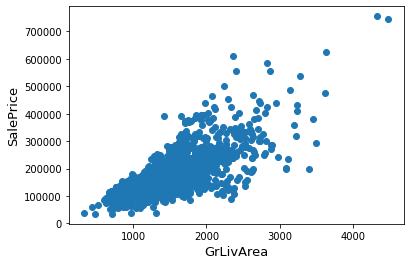

The train data size is : (1458, 81)  
The test data size is : (1459, 80) 


In [ ]:
train= train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()
print("The train data size is : {}  ".format(train.shape))
print("The test data size is : {} ".format(test.shape))

###**2. Saving the IDs and removing from datasets**

In [ ]:
train_id = train['Id']
test_id = test['Id']
train = train.drop('Id',1)
test = test.drop('Id',1)

###**3. Splitting the target variable**

In [ ]:
y_train = train['SalePrice']
x_train = train.drop('SalePrice', 1)
x_test = test

###**4. Dealing with missing values by each feature**

In [ ]:
all_data = pd.concat((x_train, x_test)).reset_index(drop=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


In [ ]:
y_train.isnull().sum()

0

We've checked that there are no missing values in the target variable.

Now, we will calculate the number and the percentage of missing values by each feature :

In [ ]:
Total = all_data.isnull().sum().sort_values(ascending=False)
Percent = (all_data.isnull().sum()/all_data.shape[0]).sort_values(ascending=False)*100
missing_data = pd.concat([Total, Percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(35)

,Total,Percent
PoolQC,2908,99.691464
MiscFeature,2812,96.400411
Alley,2719,93.212204
Fence,2346,80.425094
FireplaceQu,1420,48.680151
LotFrontage,486,16.660953
GarageCond,159,5.450806
GarageQual,159,5.450806
GarageYrBlt,159,5.450806
GarageFinish,159,5.450806


Text(0.5, 1.0, 'Percent missing data by feature')

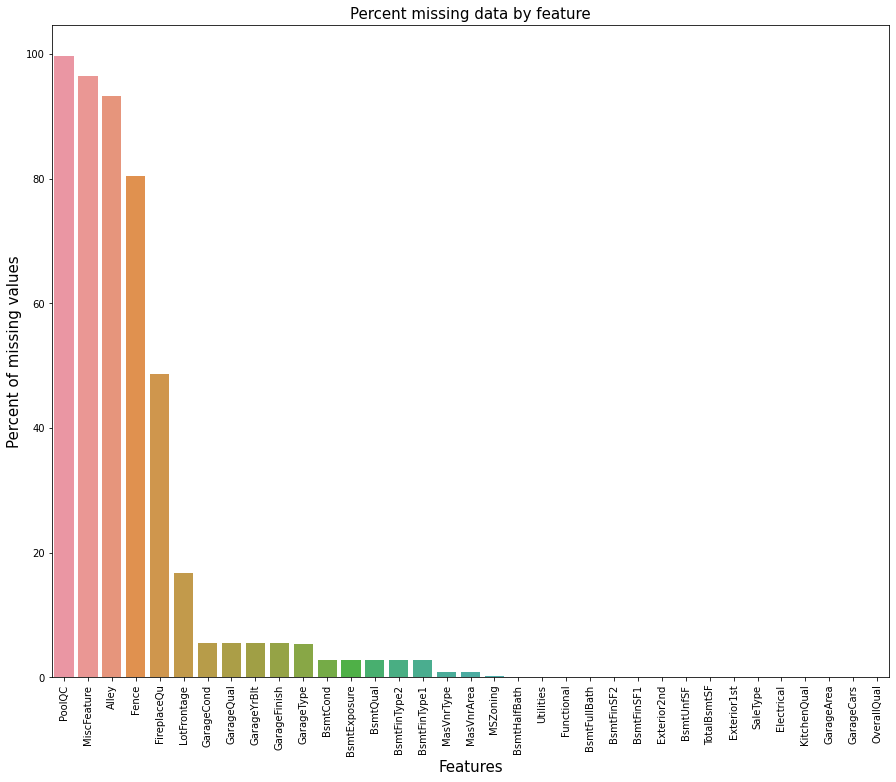

In [ ]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
Percent = Percent[:35]
sns.barplot(x=Percent.index, y=Percent)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

First, we can impute some of the missing data in the features as following:
1. PoolQC - 99% of the values are missing, and it makes sense that most of the houses does'nt have pool, so we can fill in the missing values with 'None' (no pool).
2. MiscFeature - NA means no misc feature, so we can fill in the missing values with 'None'.
3. Alley - NA means no alley access, so we can fill in the missing values with 'None'.
4. Fence - NA means no fence, so we can fill in the missing values with 'None'.
4. FireplaceQu -  NA means no fireplace, so we can fill in the missing values with 'None'.
5. LotFrontage - replacing missing values with the most common value.
6. GarageType, GarageFinish, GarageQual, GarageCond - Replacing missing values with 'None'.
7. GarageYrBlt, GarageArea, GarageCars - Replacing missing values with 0.
8. BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath - Replacing missing values with 0 for having no basement.
9. BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 - Replacing missing values with 'None' for having no basement.
10. Functional - NA means value 'typ'.
11. We will replace all other missing values with the most common value of each feature.

In [ ]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

Now all that is left is to replace all remaining missing values with the most common value of each feature.
Let us check again the number of missing values for each variable: 

In [ ]:
Total = all_data.isnull().sum().sort_values(ascending=False)
Percent = (all_data.isnull().sum()/all_data.shape[0]).sort_values(ascending=False)*100
missing_data = pd.concat([Total, Percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(12)


,Total,Percent
LotFrontage,486,16.660953
MasVnrType,24,0.822763
MasVnrArea,23,0.788481
MSZoning,4,0.137127
Functional,2,0.068564
Utilities,2,0.068564
Exterior1st,1,0.034282
SaleType,1,0.034282
Electrical,1,0.034282
Exterior2nd,1,0.034282


In [ ]:
all_data = all_data.apply(lambda x:x.fillna(x.value_counts().index[0]))
print("number of missing values : " ,all_data.isnull().sum().max())
print("all_data size is : {}".format(all_data.shape))

number of missing values :  0
all_data size is : (2917, 79)


For all the other missing values, we replaced them with the most common value in each feature. 
Now, there are no missing values in the data.

###**5. Scaling datasets**

We will scale the values of the numerical features by subtracting the mean and dividing by the standard deviation for both test and train features:

In [ ]:
for i in all_data.columns:
  if all_data[i].dtype != "object":
    all_data[i]=(all_data[i]-all_data[i].mean())/(all_data[i].std())
print('Shape of all_data dataset: {}'.format(all_data.shape))
all_data.head()

Shape of all_data dataset: (2917, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0.067343,RL,-0.125728,-0.216400,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,0.649468,-0.507416,1.047051,0.897548,Gable,CompShg,VinylSd,VinylSd,BrkFace,0.533996,Gd,TA,PConc,Gd,TA,No,GLQ,0.601411,Unf,-0.293084,-0.933602,-0.449314,GasA,Ex,Y,SBrkr,-0.783079,1.210266,-0.101215,0.426131,1.090070,-0.249767,0.783102,1.233453,0.169958,-0.207737,Gd,0.992109,Typ,-0.924604,None,Attchd,0.295069,RFn,0.307685,0.352727,TA,TA,Y,-0.739963,0.204412,-0.359678,-0.103349,-0.285992,-0.060437,None,None,None,-0.089608,-1.553066,0.157422,WD,Normal
1,-0.873122,RL,0.585667,-0.069097,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,-0.061413,2.186999,0.155579,-0.394797,Gable,CompShg,MetalSd,MetalSd,None,-0.566927,TA,TA,CBlock,Gd,TA,Gd,ALQ,1.213775,Unf,-0.293084,-0.628848,0.496033,GasA,Ex,Y,SBrkr,0.270743,-0.784504,-0.101215,-0.475443,-0.818534,3.820454,0.783102,-0.755481,0.169958,-0.207737,TA,-0.286434,Typ,0.626328,TA,Attchd,0.235046,RFn,0.307685,-0.057028,TA,TA,Y,1.615161,-0.704422,-0.359678,-0.103349,-0.285992,-0.060437,None,None,None,-0.089608,-0.447307,-0.602844,WD,Normal
2,0.067343,RL,0.016551,0.142251,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,0.649468,-0.507416,0.981016,0.849683,Gable,CompShg,VinylSd,VinylSd,BrkFace,0.343019,Gd,TA,PConc,Gd,TA,Mn,GLQ,0.106117,Unf,-0.293084,-0.287705,-0.300294,GasA,Ex,Y,SBrkr,-0.616960,1.238295,-0.101215,0.579077,1.090070,-0.249767,0.783102,1.233453,0.169958,-0.207737,Gd,-0.286434,Typ,0.626328,TA,Attchd,0.290623,RFn,0.307685,0.632106,TA,TA,Y,-0.739963,-0.078668,-0.359678,-0.103349,-0.285992,-0.060437,None,None,None,-0.089608,1.027037,0.157422,WD,Normal
3,0.302459,RL,-0.362859,-0.075501,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,0.649468,-0.507416,-1.858487,-0.681985,Gable,CompShg,Wd Sdng,Wd Shng,None,-0.566927,TA,TA,BrkTil,TA,Gd,No,ALQ,-0.501744,Unf,-0.293084,-0.046631,-0.682158,GasA,Gd,Y,SBrkr,-0.510539,0.981358,-0.101215,0.440219,1.090070,-0.249767,-1.026969,-0.755481,0.169958,-0.207737,Gd,0.352837,Typ,0.626328,Gd,Detchd,0.283954,Unf,1.619846,0.790420,TA,TA,Y,-0.739963,-0.182960,3.872900,-0.103349,-0.285992,-0.060437,None,None,None,-0.089608,-1.553066,-1.363111,WD,Abnorml
4,0.067343,RL,0.775372,0.527801,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,1.360350,-0.507416,0.947999,0.753954,Gable,CompShg,VinylSd,VinylSd,BrkFace,1.399006,Gd,TA,PConc,Gd,TA,Av,GLQ,0.486593,Unf,-0.293084,-0.160345,0.223605,GasA,Ex,Y,SBrkr,-0.032945,1.675089,-0.101215,1.408203,1.090070,-0.249767,0.783102,1.233453,1.385073,-0.207737,Gd,1.631380,Typ,0.626328,TA,Attchd,0.288400,RFn,1.619846,1.693745,TA,TA,Y,0.777432,0.547087,-0.359678,-0.103349,-0.285992,-0.060437,None,None,None,-0.089608,2.132796,0.157422,WD,Normal


###**6. Encoding the categorical features**

In [ ]:
print('The categorial features are: {}'.format(all_data.select_dtypes(include='object').columns))
print('The number of categorial features is: {}'.format(all_data.select_dtypes(include='object').columns.shape[0]))

The categorial features are: Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
The number of categorial features is: 43


We can see in the description file that some categorical variables contain information in their ordering set.
For example, the feature FireplaceQu has the categories:

Ex:	Excellent - Exceptional Masonry Fireplace

Gd:	Good - Masonry Fireplace in the main level

TA:	Average - Prefabricated Fireplace in the main living area or Masonry Fireplace in basement

Fa:	Fair - Prefabricated Fireplace in basement

Po:	Poor - Ben Franklin Stove

None:	No Fireplace

Therefore, we will do encoding for those variables in the  dataset:

In [ ]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir')

for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

print('Shape of all dataset: {}'.format(all_data.shape))
all_data.head()

Shape of all dataset: (2917, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0.067343,RL,-0.125728,-0.216400,1,1,3,Lvl,AllPub,Inside,0,CollgCr,Norm,Norm,1Fam,2Story,0.649468,-0.507416,1.047051,0.897548,Gable,CompShg,VinylSd,VinylSd,BrkFace,0.533996,2,4,PConc,2,4,3,2,0.601411,6,-0.293084,-0.933602,-0.449314,GasA,0,1,SBrkr,-0.783079,1.210266,-0.101215,0.426131,1.090070,-0.249767,0.783102,1.233453,0.169958,-0.207737,2,0.992109,6,-0.924604,3,Attchd,0.295069,2,0.307685,0.352727,5,5,2,-0.739963,0.204412,-0.359678,-0.103349,-0.285992,-0.060437,3,4,None,-0.089608,-1.553066,0.157422,WD,Normal
1,-0.873122,RL,0.585667,-0.069097,1,1,3,Lvl,AllPub,FR2,0,Veenker,Feedr,Norm,1Fam,1Story,-0.061413,2.186999,0.155579,-0.394797,Gable,CompShg,MetalSd,MetalSd,None,-0.566927,3,4,CBlock,2,4,1,0,1.213775,6,-0.293084,-0.628848,0.496033,GasA,0,1,SBrkr,0.270743,-0.784504,-0.101215,-0.475443,-0.818534,3.820454,0.783102,-0.755481,0.169958,-0.207737,3,-0.286434,6,0.626328,5,Attchd,0.235046,2,0.307685,-0.057028,5,5,2,1.615161,-0.704422,-0.359678,-0.103349,-0.285992,-0.060437,3,4,None,-0.089608,-0.447307,-0.602844,WD,Normal
2,0.067343,RL,0.016551,0.142251,1,1,0,Lvl,AllPub,Inside,0,CollgCr,Norm,Norm,1Fam,2Story,0.649468,-0.507416,0.981016,0.849683,Gable,CompShg,VinylSd,VinylSd,BrkFace,0.343019,2,4,PConc,2,4,2,2,0.106117,6,-0.293084,-0.287705,-0.300294,GasA,0,1,SBrkr,-0.616960,1.238295,-0.101215,0.579077,1.090070,-0.249767,0.783102,1.233453,0.169958,-0.207737,2,-0.286434,6,0.626328,5,Attchd,0.290623,2,0.307685,0.632106,5,5,2,-0.739963,-0.078668,-0.359678,-0.103349,-0.285992,-0.060437,3,4,None,-0.089608,1.027037,0.157422,WD,Normal
3,0.302459,RL,-0.362859,-0.075501,1,1,0,Lvl,AllPub,Corner,0,Crawfor,Norm,Norm,1Fam,2Story,0.649468,-0.507416,-1.858487,-0.681985,Gable,CompShg,Wd Sdng,Wd Shng,None,-0.566927,3,4,BrkTil,4,1,3,0,-0.501744,6,-0.293084,-0.046631,-0.682158,GasA,2,1,SBrkr,-0.510539,0.981358,-0.101215,0.440219,1.090070,-0.249767,-1.026969,-0.755481,0.169958,-0.207737,2,0.352837,6,0.626328,2,Detchd,0.283954,3,1.619846,0.790420,5,5,2,-0.739963,-0.182960,3.872900,-0.103349,-0.285992,-0.060437,3,4,None,-0.089608,-1.553066,-1.363111,WD,Abnorml
4,0.067343,RL,0.775372,0.527801,1,1,0,Lvl,AllPub,FR2,0,NoRidge,Norm,Norm,1Fam,2Story,1.360350,-0.507416,0.947999,0.753954,Gable,CompShg,VinylSd,VinylSd,BrkFace,1.399006,2,4,PConc,2,4,0,2,0.486593,6,-0.293084,-0.160345,0.223605,GasA,0,1,SBrkr,-0.032945,1.675089,-0.101215,1.408203,1.090070,-0.249767,0.783102,1.233453,1.385073,-0.207737,2,1.631380,6,0.626328,5,Attchd,0.288400,2,1.619846,1.693745,5,5,2,0.777432,0.547087,-0.359678,-0.103349,-0.285992,-0.060437,3,4,None,-0.089608,2.132796,0.157422,WD,Normal


Let us check how many categorical features are left:

In [ ]:
print('The categorial features are: {}'.format(all_data.select_dtypes(include='object').columns))
print('The number of categorial features is: {}'.format(all_data.select_dtypes(include='object').columns.shape[0]))

The categorial features are: Index(['MSZoning', 'LandContour', 'Utilities', 'LotConfig', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
       'Heating', 'Electrical', 'GarageType', 'MiscFeature', 'SaleType',
       'SaleCondition'],
      dtype='object')
The number of categorial features is: 21


For all remaining categorical features, we will use get dummies:

In [ ]:
all_data = pd.get_dummies(all_data)
print('Shape of all dataset: {}'.format(all_data.shape))

Shape of all dataset: (2917, 221)


###**7. Splitting the data to train, test and validation:**

In [ ]:
#splitting all_data to train and test
x_train = all_data[:1458]
X_test = all_data[1458:]
#splitting train dataset to train and validation
X_train = x_train[:1210]
X_val = x_train[1210:]
Y_train = y_train[:1210]
Y_val = y_train[1210:]

print('Shape of test dataset: {}'.format(X_test.shape))
print('Shape of train dataset: {}'.format(X_train.shape))
print('Shape of validation dataset: {}'.format(X_val.shape))
print('Shape of train target variable: {}'.format(Y_train.shape))
print('Shape of validation target variable: {}'.format(Y_val.shape))

Shape of test dataset: (1459, 221)
Shape of train dataset: (1210, 221)
Shape of validation dataset: (248, 221)
Shape of train target variable: (1210,)
Shape of validation target variable: (248,)


In [ ]:
X_val.head()

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,...,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1210,-0.167773,4.000359,0.255482,1,1,0,1,1.360350,1.288861,0.551789,0.993277,-0.566927,2,4,2,4,0,2,-0.026712,6,-0.293084,-0.974539,-1.140861,2,1,-0.201660,0.785151,-0.101215,0.510654,-0.818534,-0.249767,0.783102,-0.755481,1.385073,-0.207737,3,0.992109,6,-0.924604,3,...,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1211,-0.638006,-0.837122,-0.102400,1,1,3,0,-1.483176,0.390723,-1.000032,-1.639277,-0.566927,3,4,4,4,3,5,-0.213573,6,-0.293084,-0.528779,-0.877747,4,1,-1.260674,-0.784504,-0.101215,-1.662784,1.090070,-0.249767,-1.026969,-0.755481,-1.045158,-0.207737,3,-1.564976,6,-0.924604,3,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1212,0.537576,-0.362859,0.013649,1,1,0,0,-1.483176,3.085138,-0.207613,0.801819,-0.566927,3,2,4,1,0,2,0.470833,6,-0.293084,-1.274744,-0.933630,0,1,-0.513135,-0.784504,-0.101215,-1.083200,1.090070,3.820454,-2.837039,-0.755481,-3.475389,-0.207737,3,-2.204248,6,-0.924604,3,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1213,0.655134,0.063978,0.008398,1,1,0,0,-0.772295,-0.507416,-0.306665,-1.064902,-0.566927,3,4,4,4,0,1,0.777015,6,-0.293084,-0.954070,-0.288652,4,1,-0.411906,-0.784504,-0.101215,-1.004715,1.090070,-0.249767,-1.026969,-0.755481,0.169958,-0.207737,3,-0.286434,6,-0.924604,3,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1214,-0.873122,1.486766,-0.390089,1,1,0,0,-0.772295,-0.507416,-0.174595,-0.873443,-0.566927,3,4,4,4,3,5,-0.582792,3,1.916898,-0.501488,-0.360833,4,1,-0.684446,-0.784504,-0.101215,-1.216022,-0.818534,-0.249767,-1.026969,-0.755481,0.169958,-0.207737,3,-0.925705,6,-0.924604,3,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


###**8. Log-transformation of the target variable**

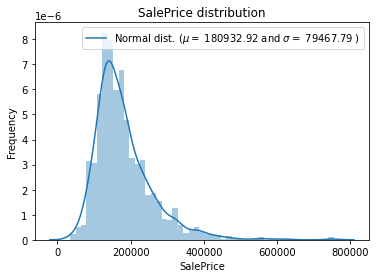

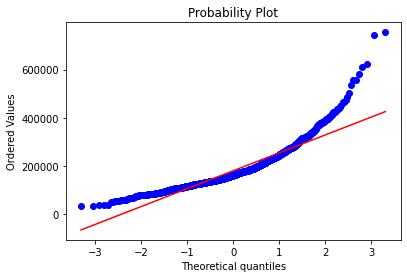

In [ ]:
sns.distplot(train['SalePrice'])
(mu, sigma) = norm.fit(train['SalePrice'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

In [ ]:
print("Skewness: %f" % train['SalePrice'].skew())

Skewness: 1.881296


The target variable SalePrice is right-skewed, meaning that the mean is biased towards a higher price than the median. It is also deviating from the normal distribution. Below we see that log(y+1) provides a nice distribution:

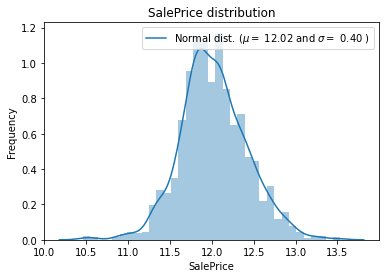

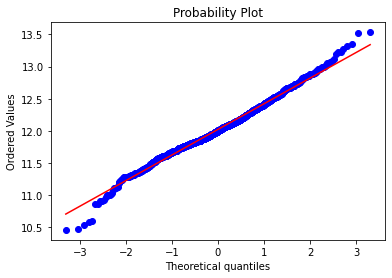

In [ ]:
sns.distplot(np.log1p(train['SalePrice']))
(mu, sigma) = norm.fit(np.log1p(train['SalePrice']))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(np.log1p(train['SalePrice']), plot=plt)
plt.show()

We see that the target variable has a more symmetric distribution in log-space, and therefore we perform the following simple transformation:

In [ ]:
Y_train = np.log1p(Y_train)
Y_val = np.log1p(Y_val)

##**Model Building**

In [ ]:
model = RidgeCV()

What makes  this regression model more effective is its ability to regularize. The term "regularizing" stands for models' ability to structurally prevent overfitting by imposing a penalty on the coefficients. 
The main tuning parameter for the regularization model is alpha - a regularization parameter that measures how flexible our model is. 
When alpha is too large the regularization is too strong, and the model cannot capture all the complexities in the data. However, if we let the model be too flexible (alpha small) the model begins to overfit. 

We will use K-fold technique for cross-validation:

In [ ]:
kfold=KFold(n_splits=5, random_state=100, shuffle=True)

##**Model** **Fitting** **and Evaluation**

###**1. Make Predictions**

We will find the optimal value of alpha and make predictions:

In [ ]:
alphas = list(np.arange(1e-3,20,1e-1)) 
clf = RidgeCV(alphas=alphas,cv=kfold).fit(X_train, Y_train)
y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)
y_test_pred = clf.predict(X_test)

###**2. Evaluate The Model**

We will use the RMSE and R^2 and evaluate how good the value of alpha that is chosen:

In [ ]:
#best alpha
print('The best value of alpha is : {}'.format(clf.alpha_))
#R^2 score
print('R^2 score for training is : {}'.format(clf.score(X_train, Y_train)))
print('R^2 score for validation is : {}'.format(clf.score(X_val, Y_val)))

#rmse score
print('RMSE for training is : {}'.format(np.sqrt(mean_squared_error(Y_train, y_train_pred))))
print('RMSE for validation is : {}'.format(np.sqrt(mean_squared_error(Y_val, y_val_pred))))

The best value of alpha is : 18.801000000000002
R^2 score for training is : 0.9373253893260599
R^2 score for validation is : 0.9099295234081932
RMSE for training is : 0.10086817857730129
RMSE for validation is : 0.11489958962635259


We found that the optimal value of alpha, such that minimize the RMSE and get the R^2 closer to 1 is alpha = 18.8.

For the Ridge regression, we get a RMSE of about 0.1008 for training and 0.114 for validation.

###**3. Inverse-transformation of the target variable**

We will inverse transfom the values of the target and the predictions:

In [ ]:
y_train1 = np.exp(Y_train)-1
y_val1 = np.exp(Y_val)-1
y_train_pred1 = np.exp(y_train_pred)-1
y_val_pred1 = np.exp(y_val_pred)-1
y_test_pred1 = np.exp(y_test_pred)-1

###**4. Results Presentation**

Text(0.5, 1.0, 'RidgeCV Regression Model - Training Results\n')

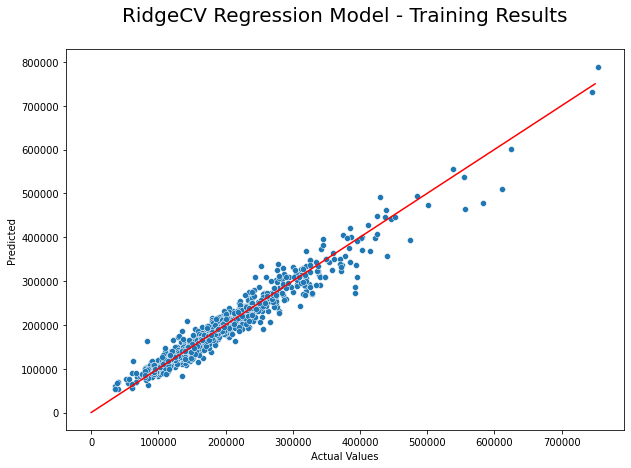

In [ ]:
predict_data1 = pd.DataFrame({"Actual Values" : y_train1, "Predicted" : y_train_pred1})
plt.figure(figsize=(10, 7))
sns.scatterplot(data = predict_data1, x = "Actual Values", y = "Predicted")
sns.lineplot(x = [0, 750000], y = [0, 750000],  color = "red")
plt.title("RidgeCV Regression Model - Training Results\n", fontsize = 20)

Text(0.5, 1.0, 'RidgeCV Regression Model - Validation Results\n')

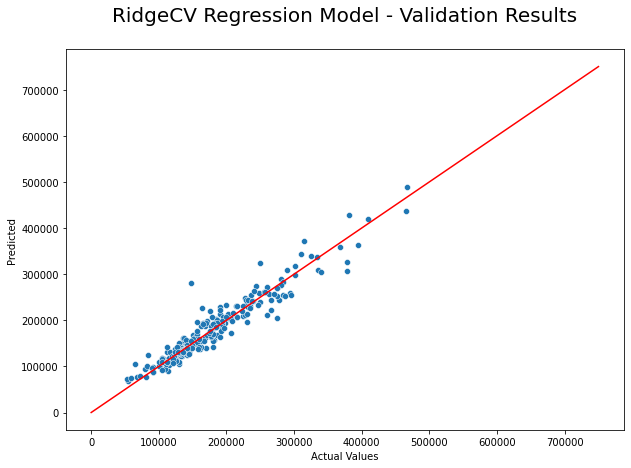

In [ ]:
predict_data = pd.DataFrame({"Actual Values" : y_val1, "Predicted" : y_val_pred1})
plt.figure(figsize=(10, 7))
sns.scatterplot(data = predict_data, x = "Actual Values", y = "Predicted")
sns.lineplot(x = [0, 750000], y = [0, 750000],  color = "red")
plt.title("RidgeCV Regression Model - Validation Results\n", fontsize = 20)

We can see that there is a linear connection between the predicted values and the actual values in the training and the validation (besides a few outliers).
Therefore, the model we build fits well.

###**5. Submission**

In [ ]:
my_submission = pd.DataFrame({'Id': test_id, 'SalePrice': y_test_pred1})
print(my_submission)
my_submission.to_csv('submission.csv', index=False)

        Id      SalePrice
0     1461  117108.013634
1     1462  159831.138955
2     1463  177329.580431
3     1464  197569.065651
4     1465  194753.507250
...    ...            ...
1454  2915   87426.511591
1455  2916   83052.761238
1456  2917  176729.322211
1457  2918  114684.703011
1458  2919  230194.353121

[1459 rows x 2 columns]
